# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

### Постановка задачи (задача достижимости)
Дан граф $G = $; $ℒ$ - регулярный язык 

Требуется найти $R' =  \{(v_i, v_j)| w(v_i \pi v_j) \in L\}$

В данном эксперименте исследуются следующие задачи достижимости, решаемые в предыдущих работах:
- Достижимость между всеми парами вершин.

- Достижимость для каждой из заданного множества стартовых вершин.

В ходе данного эксперимента будут рассмотрены следующие вопросы, на которые будут получены ответы:
- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

### Описание исследуемых решений
Для решения исследуемых задач были реализованы следующие методы:

- Достижимость между всеми парами вершин: Метод с использованием тензорного произведения $-$ строятся матрицы смежности графа (который можно представить в виде конечного автомата) и конечного автомата, который задает запрос, а затем тензорно перемножаются. Полученная матрица распознает уже пересечение двух автоматов. Далее, путем возведения в степень данной матрицы, находится транзитивное замыкание, по которому определяются искомые пары вершин.

- Достижимость для каждой из заданного множества стартовых вершин: Метод, использующий идею MS BFS $-$ конечный автомат и граф синхронно обходится в ширину. Для каждой вершины из заданного множества стартовых вершин строится отдельная матрица, хранящая информацию о том, в каких вершинах мы находимся на данный момент, эти матрицы соединяются вертикально в единую матрицу `frontier`. Также мы используем матрицу `is_visited`, храняющую информацию об уже посещенных вершинах, которая изначально равна `frontier`. В ходе самого алгоритма мы строим новых `frontier` путем умножения старого на матрицу смежности графа. После получения нового `frontier`, `is_visited` обновляется. Сам процесс продолжается пока в `frontier` не останется ненулевых элементов. Искомые пары для каждой стартовой вершины выбираются из соответствующей части `is_visited`

В данных методах были использованы разряженные матрицы из библиотеке `scipy`

### Описание вычислительной машины

- Processor	12th Gen Intel(R) Core(TM) i7-12700H   2.30 GHz
- Installed RAM	16.0 GB (15.7 GB usable)
- System type 64-bit operating system, x64-based processor

### Описание используемого ПО

- Операционная система Linux Mint 22
- Python 3.12.7

### Окружение

- Необходимые зависимости указаны в `req_experiment.txt`

### Описание эксперимента

- Для ответа на первый вопрос были выбраны самые используемые матрицы из `scipy.sparse` $-$ `csr_matrix`, `dok_matrix`, `lil_matrix`, `csc_matrix`. Для каждого типа матриц оба алгоритма были запущены каждом графе и рег. выражении. Из 20 запусков бралось среднее время работы и стандартное отклонение.

- Для ответа на второй вопрос, для каждого регулярного выражения измеряется время работы алгоритма по количеству стартовых вершин. алгоритмы также запускаются 20 раз, чтобы получить среднее время выполнения для каждого количества стартовых вершин.

Шаги, замеры, анализ результатов и вывод для этих вопросов будут указаны далее 

### Импорты

In [1]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np
import time
import cfpq_data
import warnings

from project.adjacency_matrix_fa import tensor_based_rpq
from project.bfs_rpq import ms_bfs_based_rpq
from collections import Counter
from scipy import stats
from scipy.sparse import SparseEfficiencyWarning
from project.graph_lib import get_graph_info_by_name
from scipy.sparse import dok_matrix, lil_matrix, csc_matrix, csr_matrix

import sources directory


Отключить <INFO> логи, ворнинги

In [61]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

### Описание набора данных для экспериментов

#### Графы
Для эксперемента были выбраны следующие графы из `CFPQ_Data`, информация о количестве вершин и ребер представлена на графике:

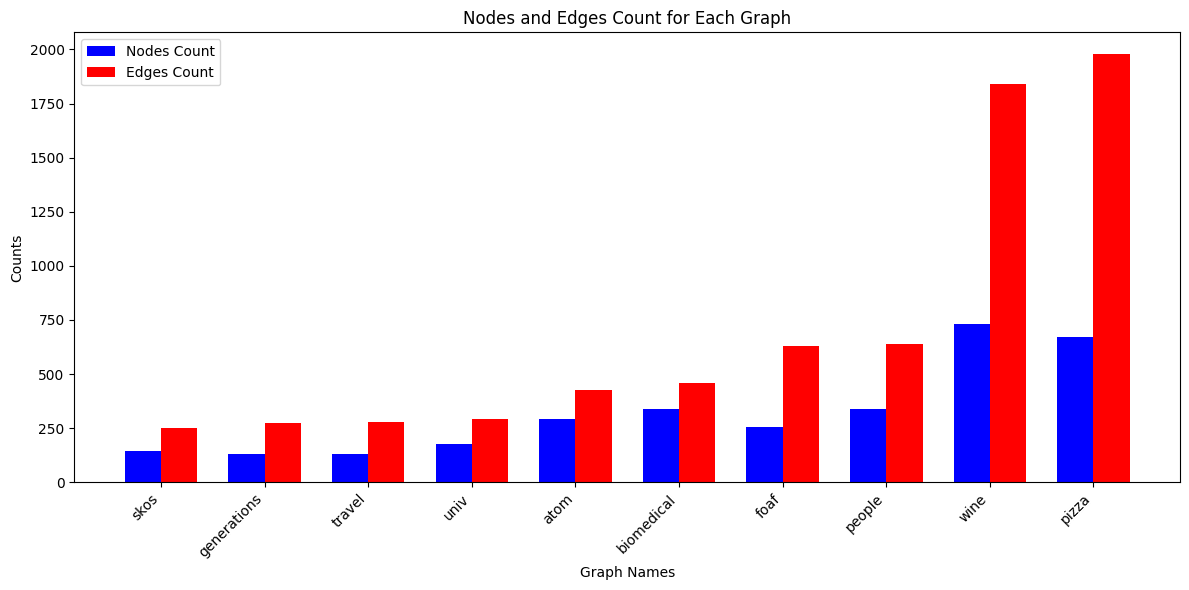

In [62]:
experiment_graphs = [
    "skos",
    "generations",
    "travel",
    "univ",
    "atom",
    "biomedical",
    "foaf",
    "people",
    "wine",
    "pizza",
]

graph_names = []
node_counts = []
edge_counts = []

for graph_name in experiment_graphs:
    graph_info = get_graph_info_by_name(graph_name)
    graph_names.append(graph_name)
    node_counts.append(graph_info.nodes_count)
    edge_counts.append(graph_info.edges_count)

x = range(len(graph_names))

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
ax.bar(x, node_counts, width=bar_width, label="Nodes Count", color="b", align="center")
ax.bar(
    [i + bar_width for i in x],
    edge_counts,
    width=bar_width,
    label="Edges Count",
    color="r",
    align="center",
)

ax.set_xlabel("Graph Names")
ax.set_ylabel("Counts")
ax.set_title("Nodes and Edges Count for Each Graph")
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(graph_names, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

Выбор этих графов обусловлен рядом причин: у каждого из них достаточное количество различных меток на ребрах (> 4), что позволяет работать с более содержательными и сложными регулярными выражениями. В наборе присутствуют различные по размеру графы $-$ малые, например `skos` с 252 ребрами и 144 вершинами, и большие, `pizza` с 1980 ребрами и 671 вершинами, что делает датасет более разнообразным и содержательным. В силу ограниченности по оборудованию, не были рассмотрены графы начиная с `core` и далее, так как один запуск алгоритма занимал $$ 10 минут, а всего эксперимента около 20 часов

#### Запросы
В данном эксперементе были использованы следующие регулярные выражения в качестве запросов:

1. `(l1 | l2)* l3`
2. `(l3 | l4)+ l1*`
3. `l1 l2 l3 (l4|l1)*`
4. `(l1 l2) | l2*`

В данных запросах используются все общепринятые конструкции регулярных выражений (замыкание, конкатенация, альтернатива). В качестве меток $l_i$, для каждого графа были взяты наиболее часто встречающиеся 

#### Код для построяния данных выражений

In [63]:
def build_most_common_labels(four_frequent_labels):
    l1 = str(four_frequent_labels[0])
    l2 = str(four_frequent_labels[1])
    l3 = str(four_frequent_labels[2])
    l4 = str(four_frequent_labels[3])
    return [
        f"({l1}|{l2})* {l3}",
        f"({l3}|{l4})+ {l1}*",
        f"{l1} {l2} {l3} ({l4}|{l1})*",
        f"({l1}{l2})| {l2}*",
    ]

#### Функции для замеров и рисования графиков для вопроса №1
Замеры происходят следующим образом:

- Загружаются графы из датасета.

- Генерируются регулярные выражения на основе самых распространённых меток графов.

- Для каждого регулярного выражения и каждого типа матрицы, запускается выбранный алгоритм `rpq` несколько раз (определенное количество запусков).

- Измеряется время выполнения каждого запуска.

- Рассчитывается среднее время и стандартное отклонение для каждого типа матрицы.

- Строятся графики для визуализации полученных данных, показывая время выполнения и отклонения для разных матричных представлений.

In [64]:
colors = ["black", "green", "orange", "purple"]
legends = ["(l1 | l2)* l3", "(l3 | l4)+ l1*", "l1 l2 l3 (l4 | l1)*", "(l1 l2) | l2*"]
number_of_launches = 20
matrix_representations = [lil_matrix, dok_matrix, csr_matrix, csc_matrix]


def print_diagram(
    matrix_representations, graph_name, matrix_time, matrix_deviation, ax
):
    num_bars = len(matrix_time[matrix_representations[0].__name__])
    width = 0.175
    id = np.arange(num_bars)

    ax.set_title(graph_name)
    colors = ["red", "green", "purple", "black"]

    for margin, matrix_representation in enumerate(matrix_representations):
        times = matrix_time[matrix_representation.__name__]
        deviations = matrix_deviation[matrix_representation.__name__]

        if len(times) != len(deviations):
            print(
                f"Error: Length mismatch for {matrix_representation.__name__}: times({len(times)}) vs deviations({len(deviations)})"
            )
            continue

        ax.bar(
            id + width * margin,
            times,
            width,
            yerr=deviations,
            error_kw={
                "ecolor": "red",
                "capsize": 8,
                "elinewidth": 2,
                "linestyle": "--",
            },
            alpha=0.7,
            color=colors[margin],
            label=matrix_representation.__name__,
        )

    ax.set_xticks(id + width * (len(matrix_representations) - 1) / 2)
    ax.set_xticklabels(legends[:num_bars])
    ax.legend(loc="upper left")


def rpq_matrix_type_experiment(
    rpq, start_states_percent=10, matrix_representations=matrix_representations
):
    num_graphs = len(experiment_graphs)
    num_cols = 3
    num_rows = (num_graphs + num_cols - 1) // num_cols  # Calculate required rows

    _, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, graph_name in enumerate(experiment_graphs):
        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        most_common_labels = Counter(
            list(map(lambda node: node[2]["label"], graph.edges.data()))
        ).most_common(4)
        labels = [pair[0] for pair in most_common_labels]
        regexes = build_most_common_labels(labels)

        start_vertices = (
            cfpq_data.generate_multiple_source_percent(
                graph, start_states_percent, seed=42
            )
            if rpq == ms_bfs_based_rpq
            else {}
        )

        matrix_time = {
            "lil_matrix": [],
            "dok_matrix": [],
            "csr_matrix": [],
            "csc_matrix": [],
        }
        matrix_deviation = {
            "lil_matrix": [],
            "dok_matrix": [],
            "csr_matrix": [],
            "csc_matrix": [],
        }

        for regex in regexes:
            for matrix_representation in matrix_representations:
                launches = list()

                for _ in range(number_of_launches):
                    start_time = time.time()

                    rpq(
                        graph=graph,
                        regex=regex,
                        start_nodes=start_vertices,
                        final_nodes={},
                        matrix_representation=matrix_representation,
                    )

                    launches.append(time.time() - start_time)

                average_time = np.mean(launches)
                deviation = stats.tstd(launches)
                matrix_time[matrix_representation.__name__].append(average_time)
                matrix_deviation[matrix_representation.__name__].append(deviation)

        print_diagram(
            matrix_representations, graph_name, matrix_time, matrix_deviation, axes[idx]
        )

    # Hide any unused axes
    for j in range(num_graphs, num_rows * num_cols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

#### Функция для замеров и рисования графиков для вопроса №2
Замеры происходят следующим образом:

- Создаются подграфики для каждого графа.

- Из датасета загружаются графы и извлекаются самые распространенные метки для генерации регулярных выражений.

- Делается несколько запусков выбранного алгоритма RPQ, измеряется время выполнения метода, для разных процентов количества стартовых вершин относительно общего количество вершин, затем берется среднее значение.

- Строются графики для визуализации результатов с легендой для различия регулярных выражений.


In [65]:
def rpq_methods_comparison(rpq=tensor_based_rpq):
    num_graphs = len(experiment_graphs)
    num_cols = 3
    num_rows = (num_graphs + num_cols - 1) // num_cols

    _, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for idx, name in enumerate(experiment_graphs):
        ax = axes[idx]
        ax.set_title(name, fontsize=20)
        graph = cfpq_data.graph_from_csv(cfpq_data.download(name))
        labels = [node[2]["label"] for node in graph.edges.data()]
        most_common_labels = Counter(labels).most_common(4)
        regexes = build_most_common_labels(most_common_labels)

        start_nodes_percentage = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 35, 65, 80, 100]
        index = np.arange(len(start_nodes_percentage))
        ax.set_xticks(index)
        ax.set_xticklabels(start_nodes_percentage)

        data = dict()
        for idx, regex in enumerate(regexes):
            value = list()

            for percentage in start_nodes_percentage:
                launches = list()
                for _ in range(number_of_launches):
                    start_time = time.time()
                    rpq(
                        graph=graph,
                        regex=regex,
                        start_nodes=cfpq_data.generate_multiple_source_percent(
                            graph, percentage, seed=42
                        ),
                        final_nodes={},
                    )
                    launches.append(time.time() - start_time)
                value.append(np.mean(launches))

            data[idx] = value

        df = pd.DataFrame(data)

        for i, col in enumerate(colors):
            if i < len(df.columns):
                ax.plot(index, df[i], color=col, label=legends[i])

        ax.legend(loc="upper left")

    for j in range(num_graphs, num_rows * num_cols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

## Вопрос №1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

### Сделаем замеры для `tensor_based_rpq`

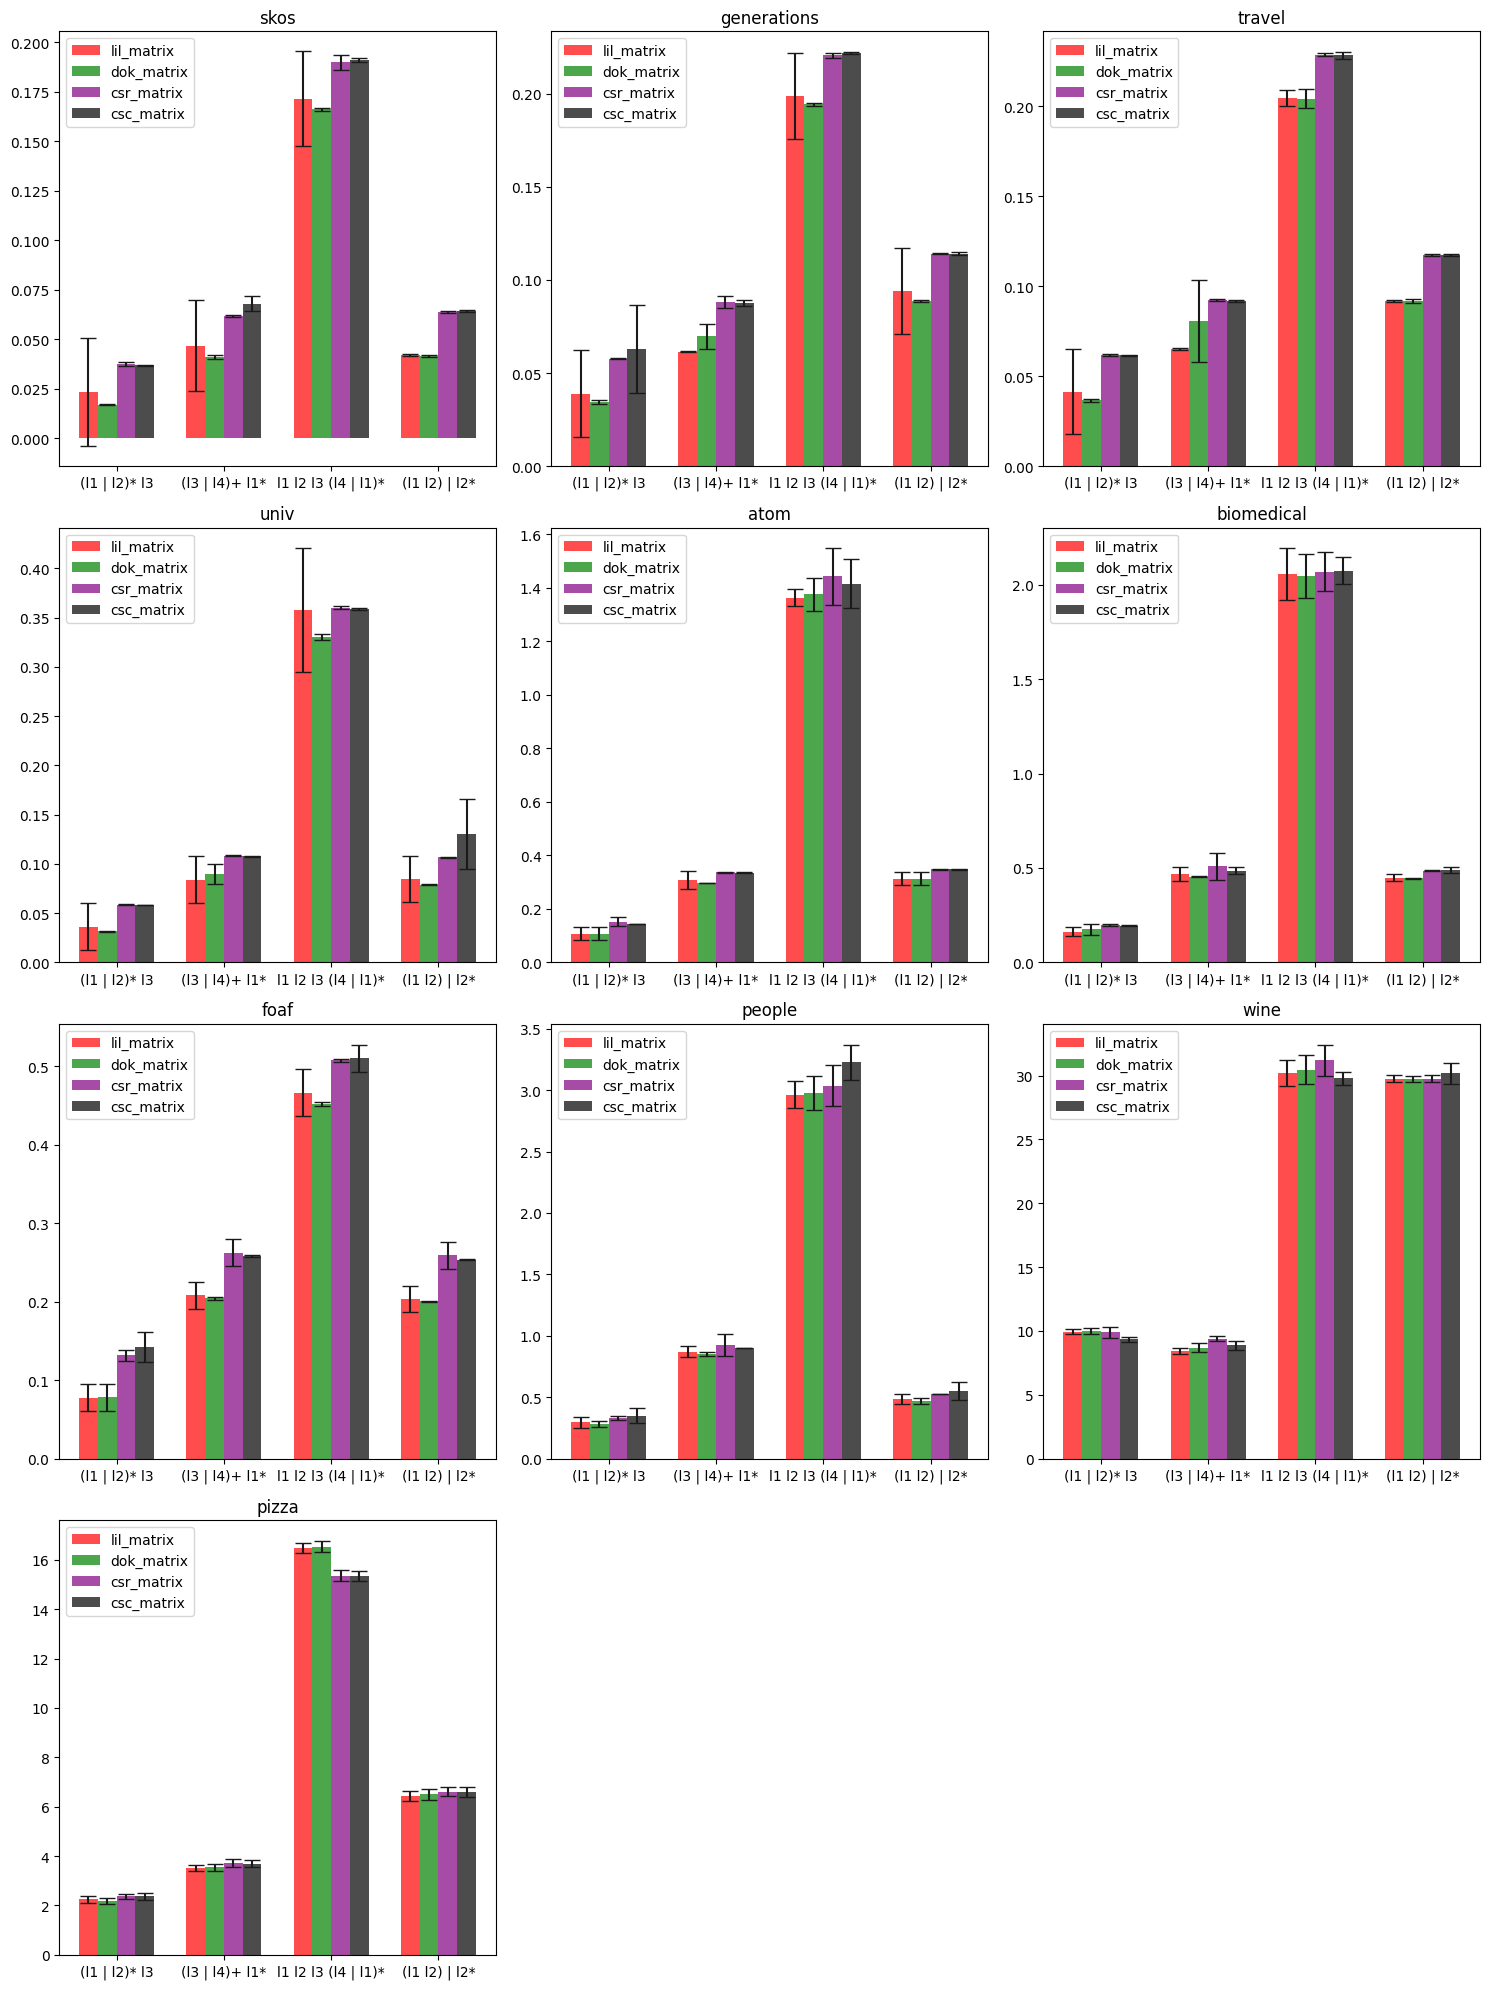

In [66]:
rpq_matrix_type_experiment(tensor_based_rpq)

### В виду того что производительность `ms_bfs_based_rpq` зависит от количества стартовых вершин, сделаем замеры для нескольких случаев:

#### `ms_bfs_based_rpq` с 10% стартовых вершин

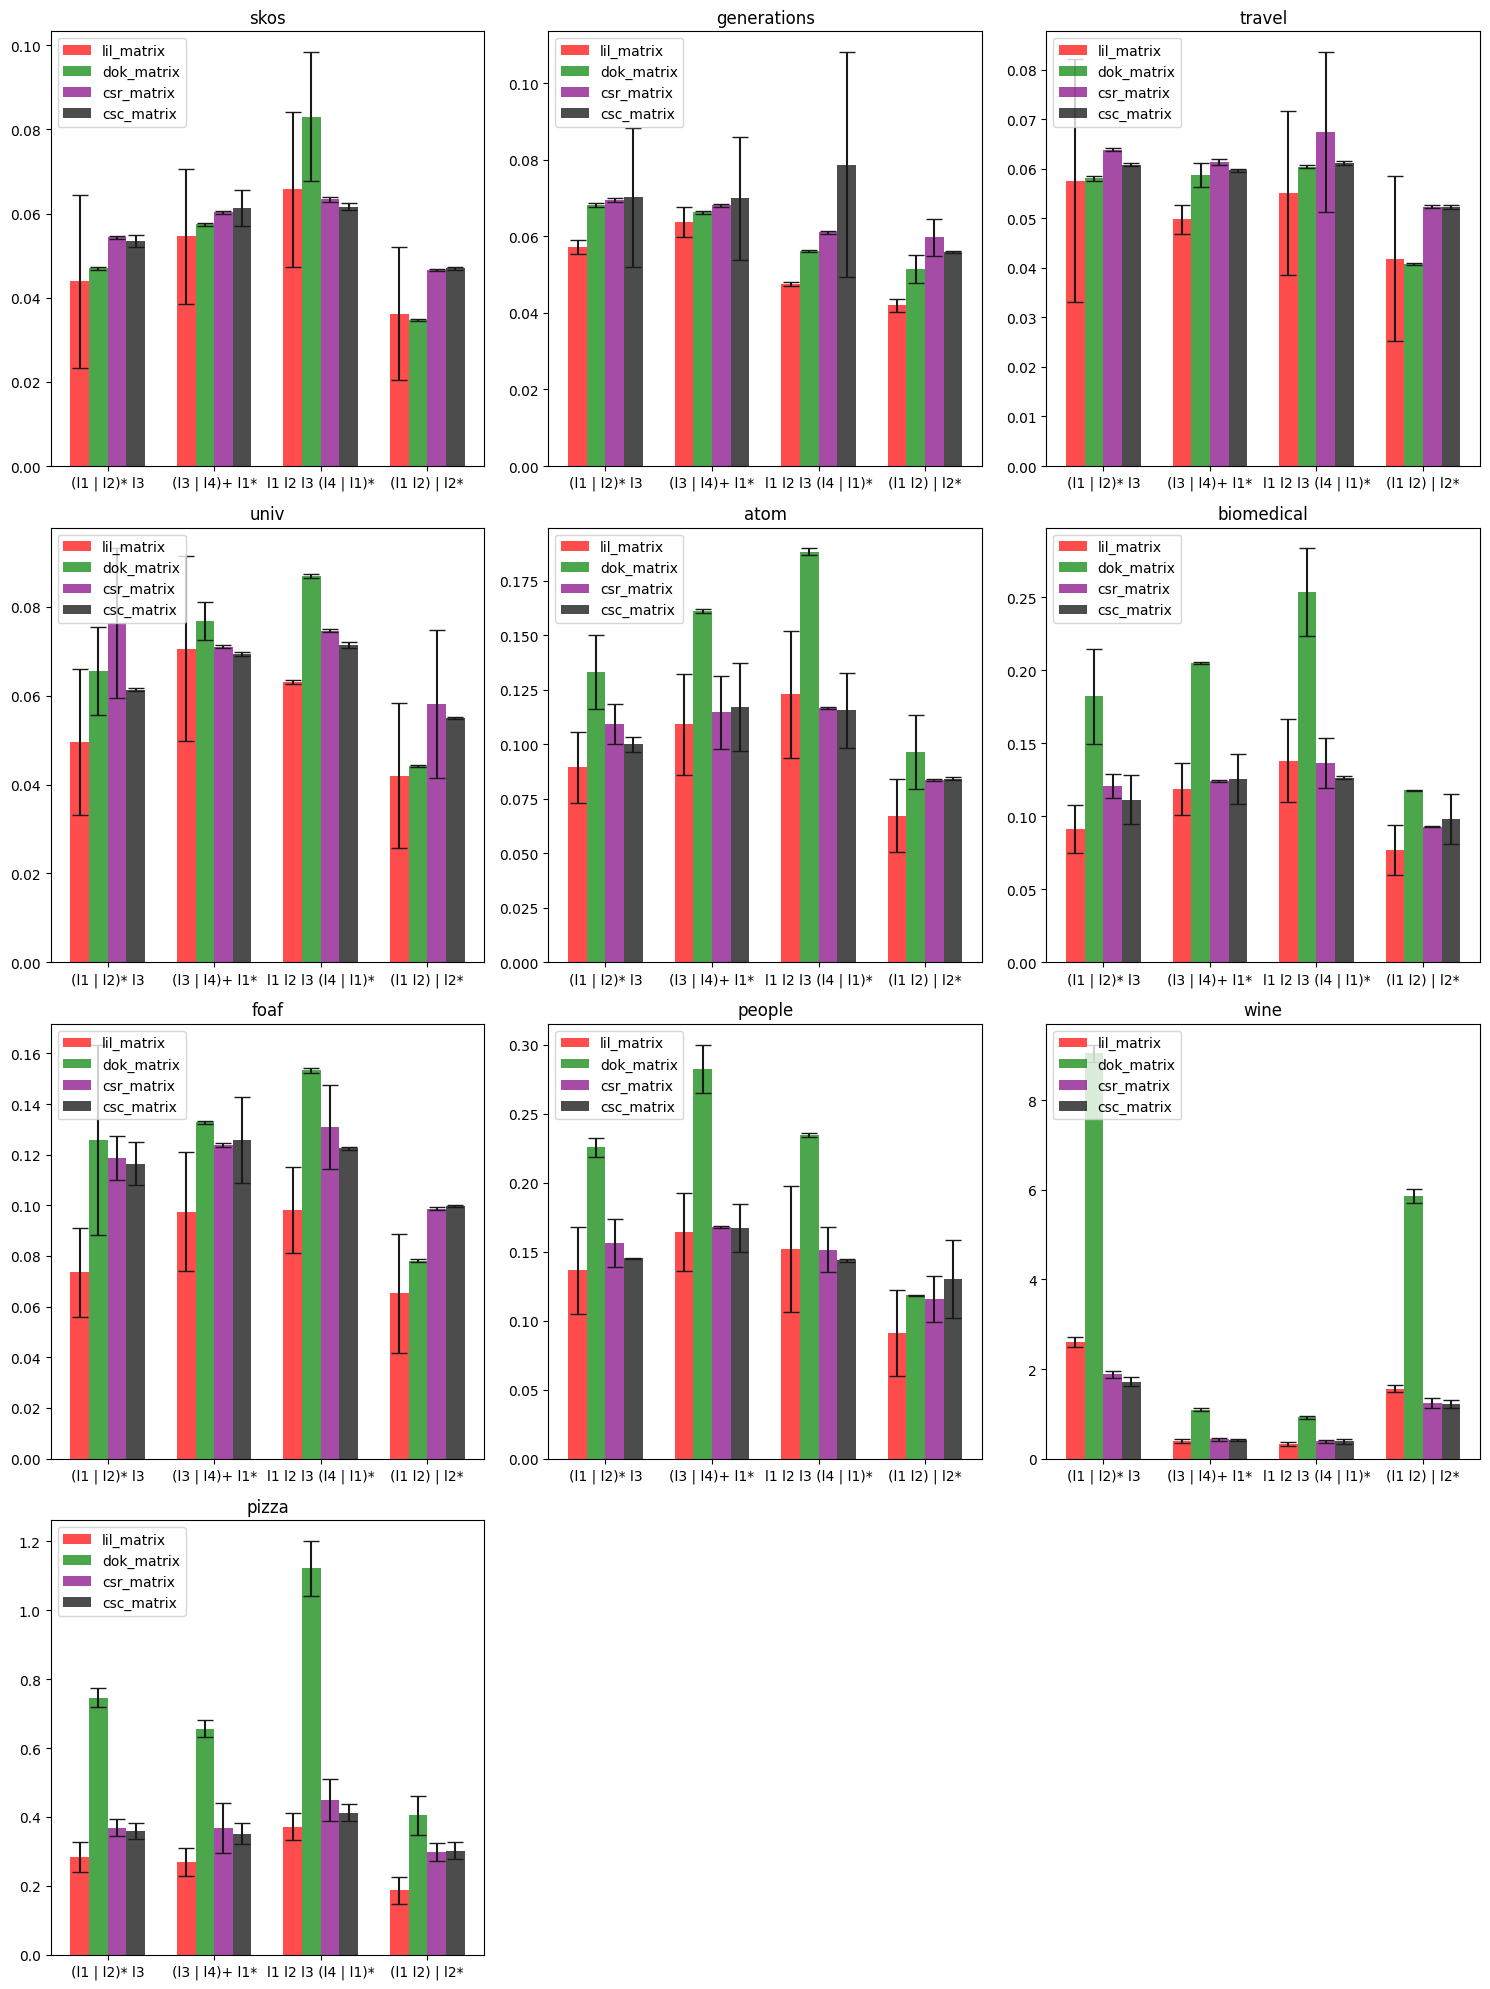

In [67]:
rpq_matrix_type_experiment(ms_bfs_based_rpq, 10)

#### `ms_bfs_based_rpq` с 20% стартовых вершин

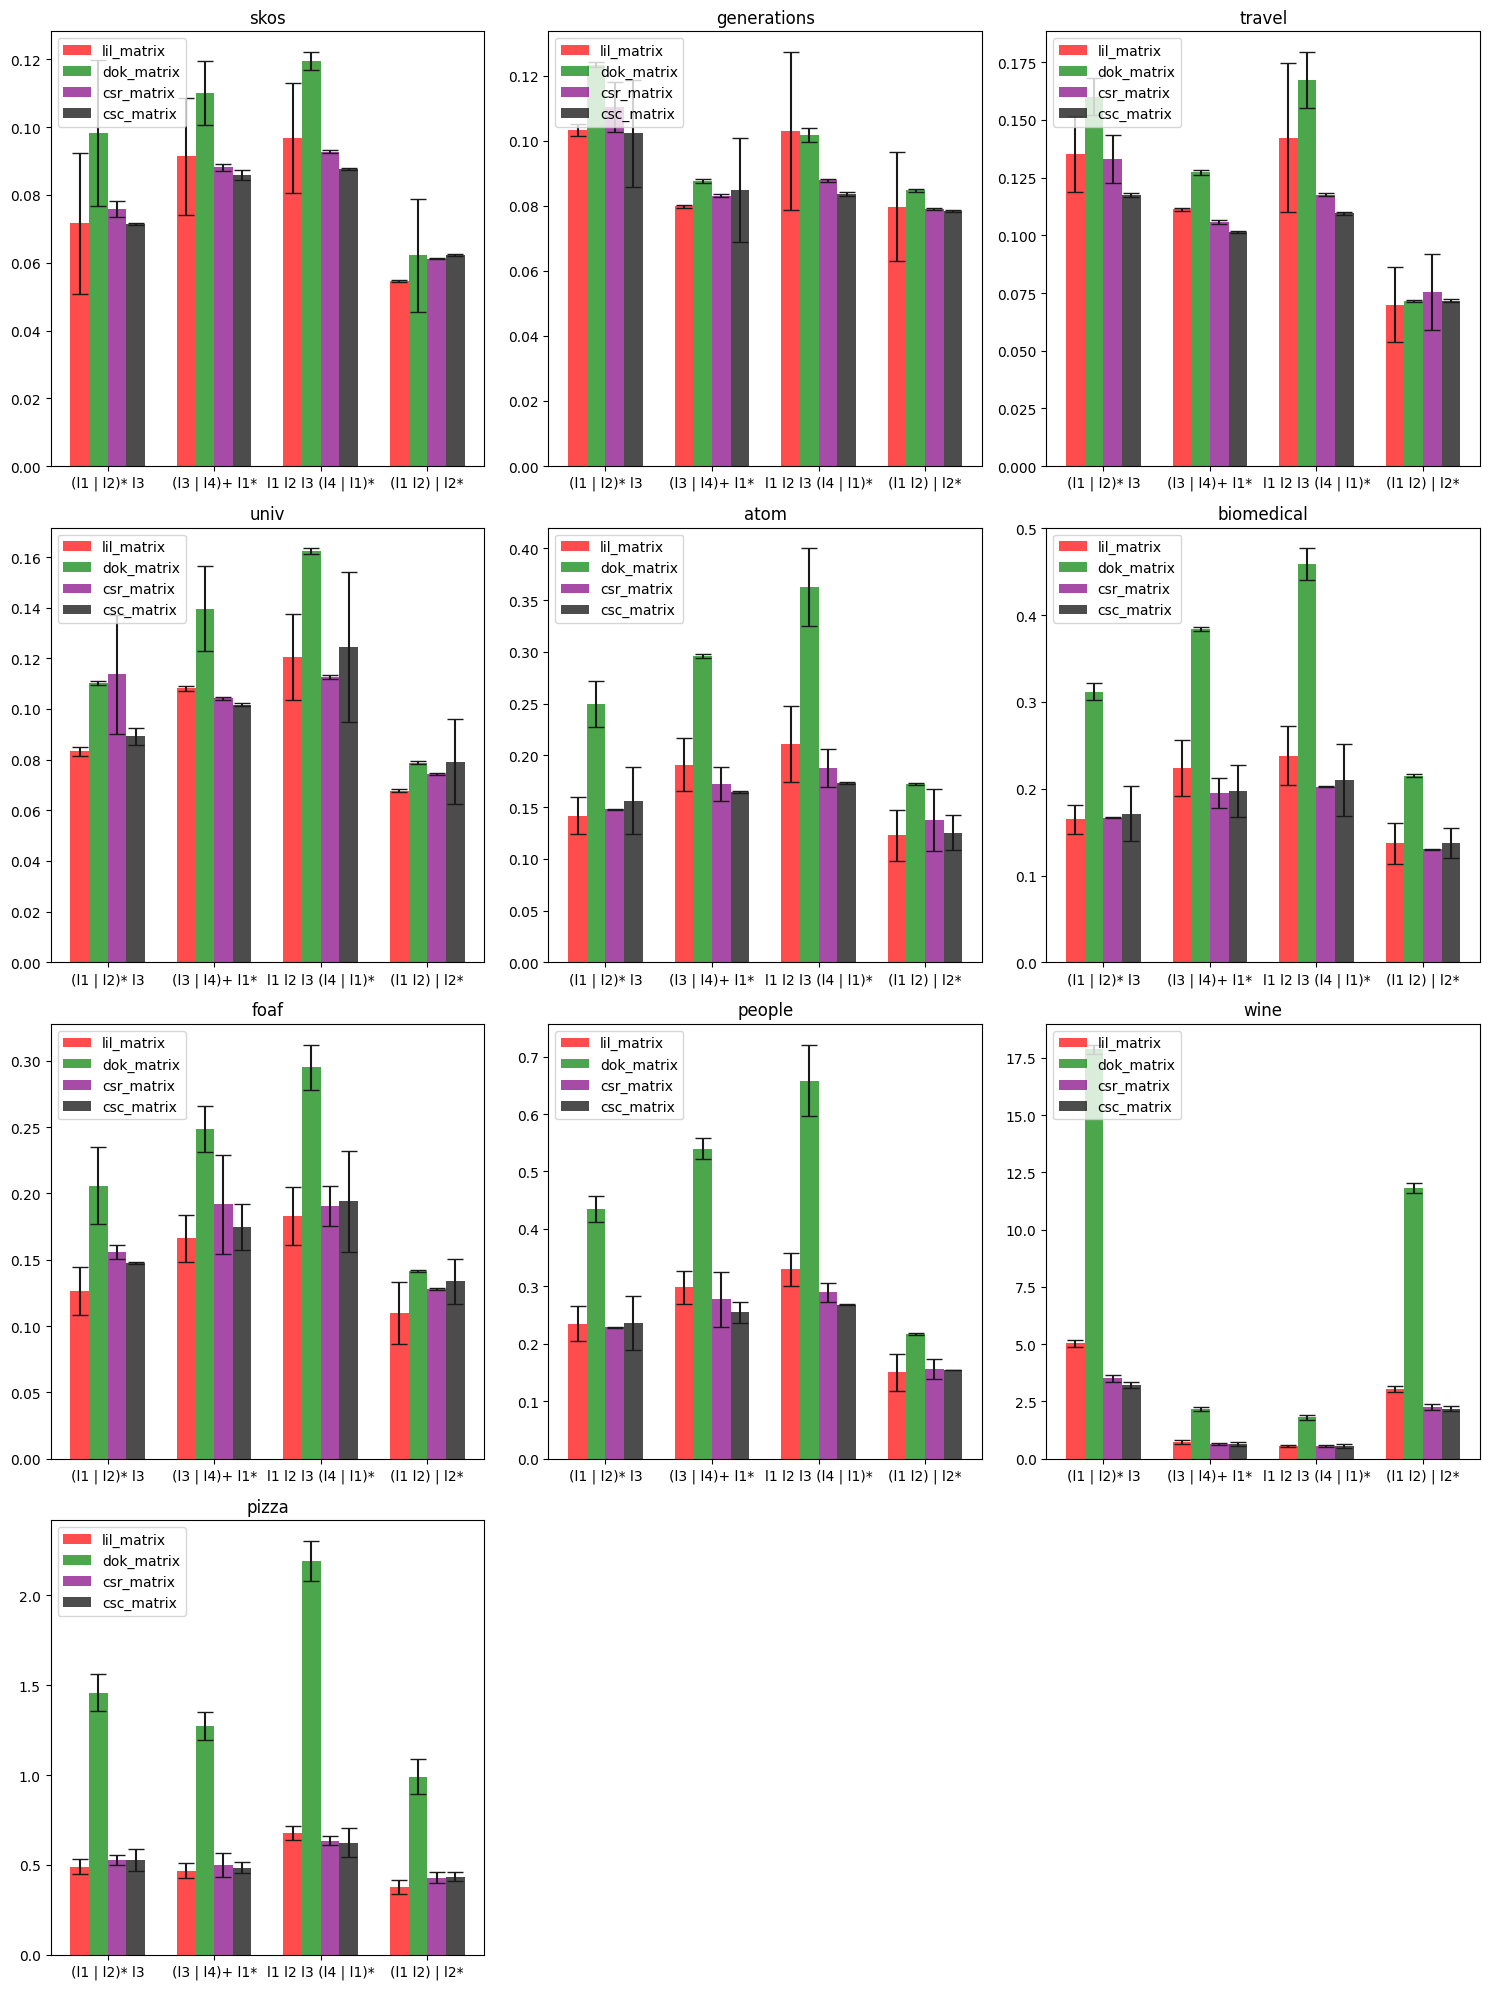

In [68]:
rpq_matrix_type_experiment(ms_bfs_based_rpq, 20)

#### `ms_bfs_based_rpq` с 30% стартовых вершин

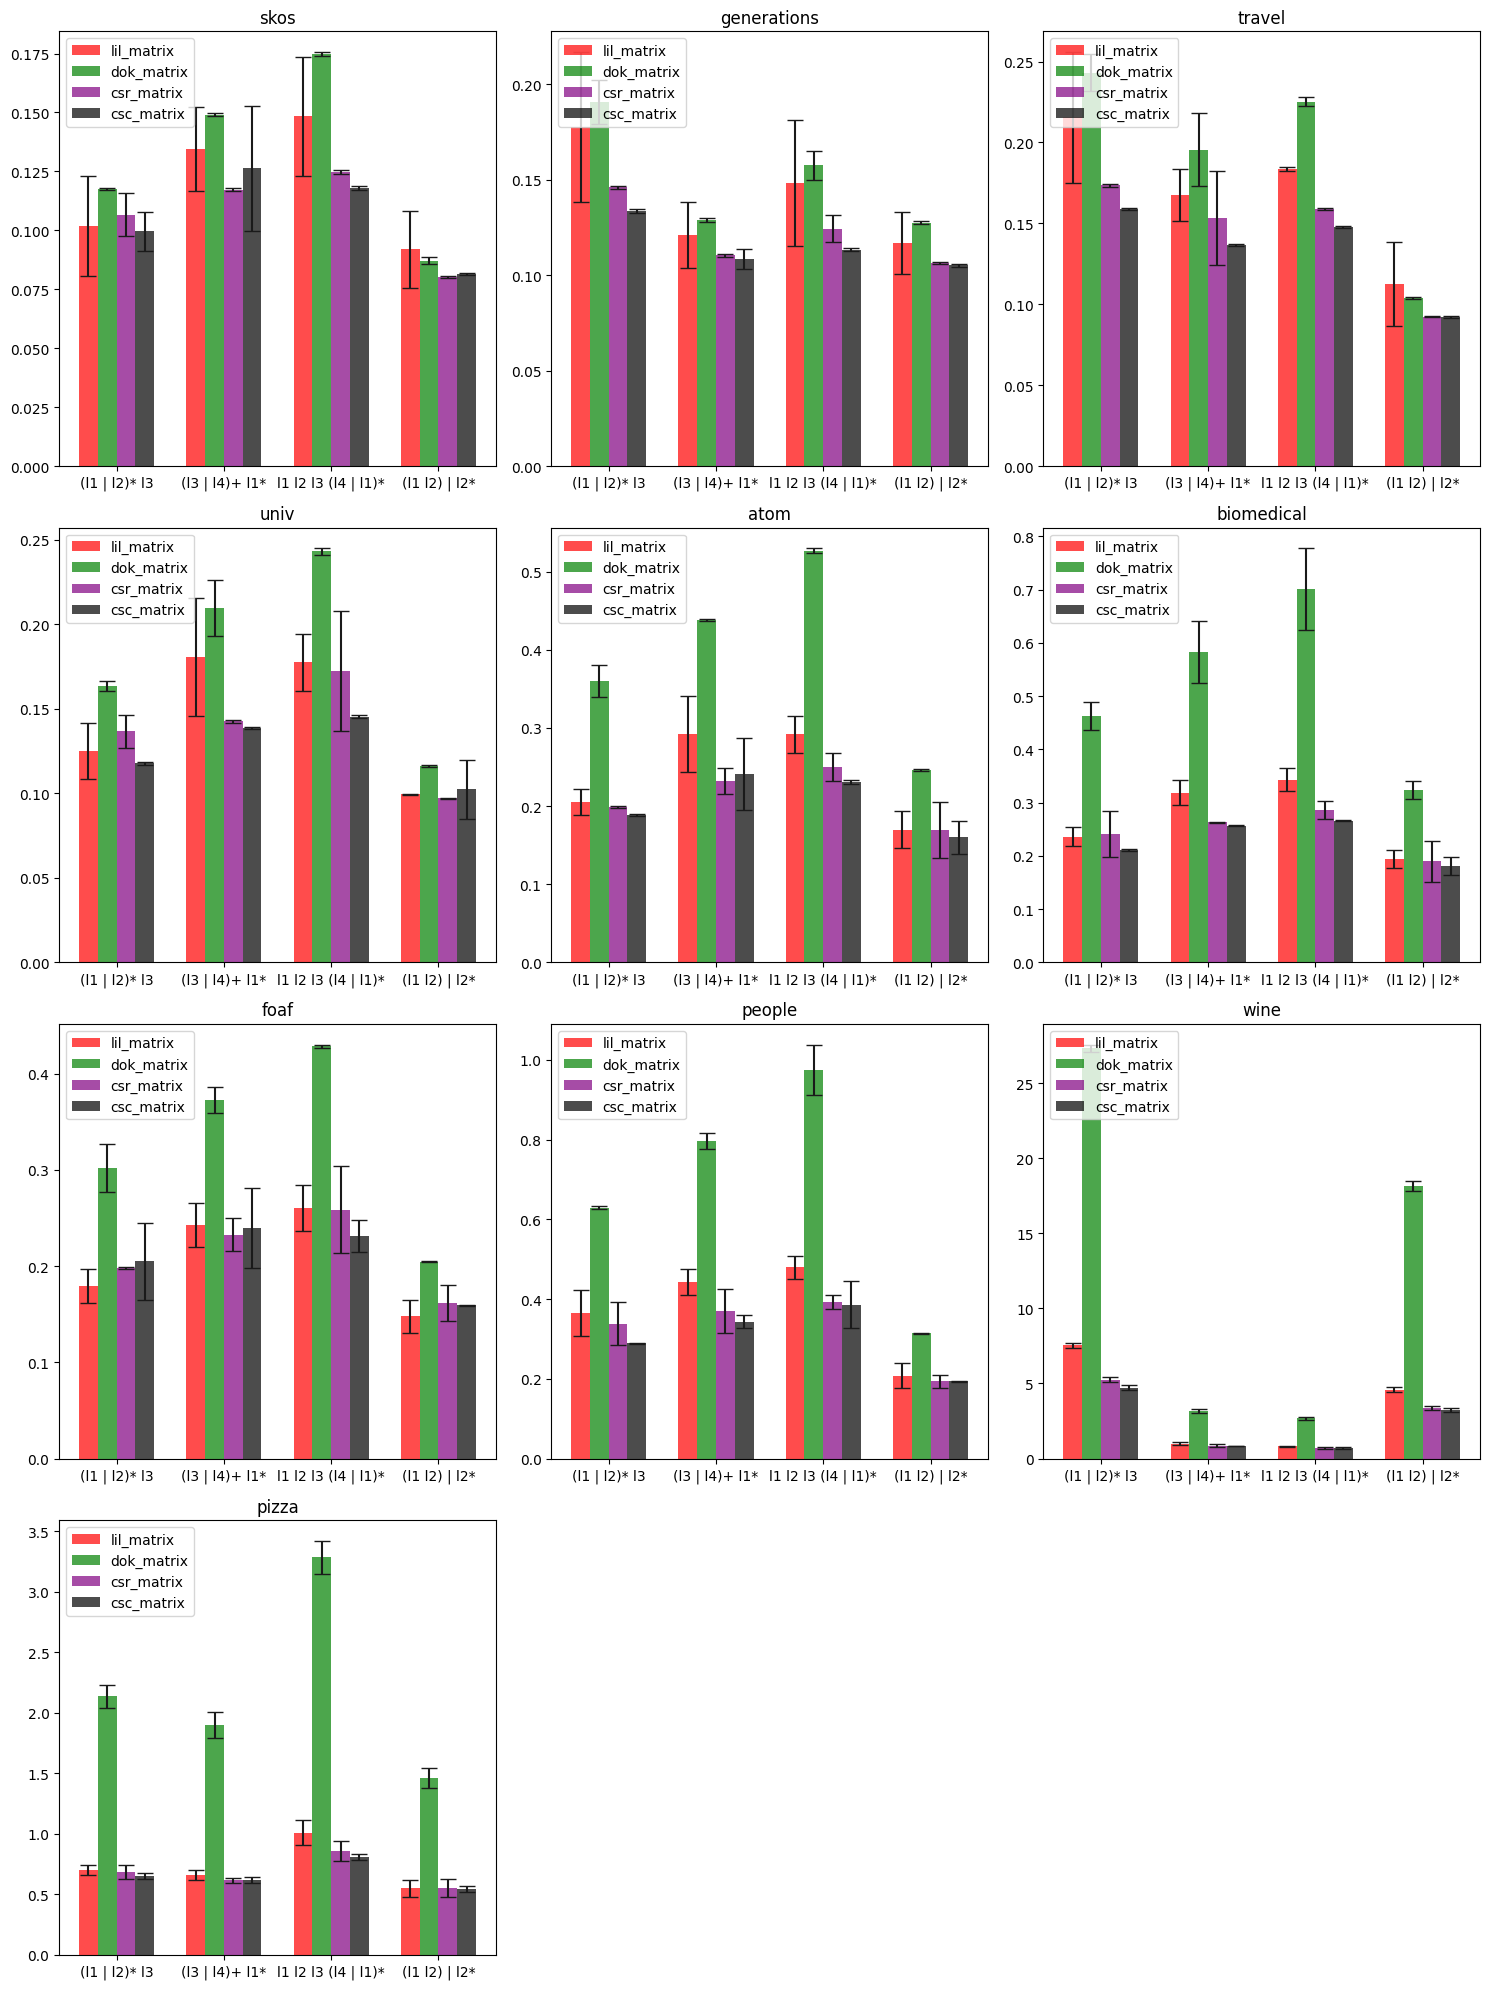

In [69]:
rpq_matrix_type_experiment(ms_bfs_based_rpq, 30)

### Вывод:

#### `tensor_based_rpq`
Результаты показали, что разница между выбором матрицы невелика, особенно с ростом размера графа. Однако, `csr_matrix` и `csc_matrix` показали себя хуже всего относительно других. `dok_matrix` и `lil_matrix` были наиболее производительными, `dok_matrix` была более эффективное на маленьких графах, в то время как `lil_matrix` начала выигрывать по производительности на бОльших графах

#### `ms_bfs_based_rpq` 
#### $10$% стартовых вершин
Хуже всего оказалась матрица `dok_matrix`, а лучше всего `lil_matrix`. `csr_matrix` и `csc_matrix` $-$ не лучший вариант, т.к они оказались менее производительными чем `lil_matrix`, при этом `csr_matrix` была чуть хуже чем `csc_matrix`
#### $20$% стартовых вершин
`dok_matrix` по-прежнему самая неэффективная, в то время как `lil_matrix` сильно упала по производительности, в большинстве случаев уступая `csr_matrix` и `csc_matrix`. В данном случае `csc_matrix` будет лучшим выбором, которая лишь иногда уступала `csr_matrix` по производительности
#### $30$% стартовых вершин
Результаты близки к предыдущим ($20$%), однако `lil_matrix` показала себя ещё хуже в этот раз. `csc_matrix` остаётся лучшим выбором, продолжая лишь иногда уступать `csr_matrix` по производительности

Аргументировать же полученные результаты можно тем, что `lil_matrix` и `dok_matrix` более эффективны при динамических изменениях матриц, что является важным в тензорном алгоритме, в то время как `csr_matrix` `csc_matrix` более эффективны для обхода по ним, что важно для `ms_based_bfs`

## Вопрос №2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Для начала сделаем замеры для `tensor_based_rpq`, взяв за тип матрицы `csr_matrix`, как было сделано изначально в дз:

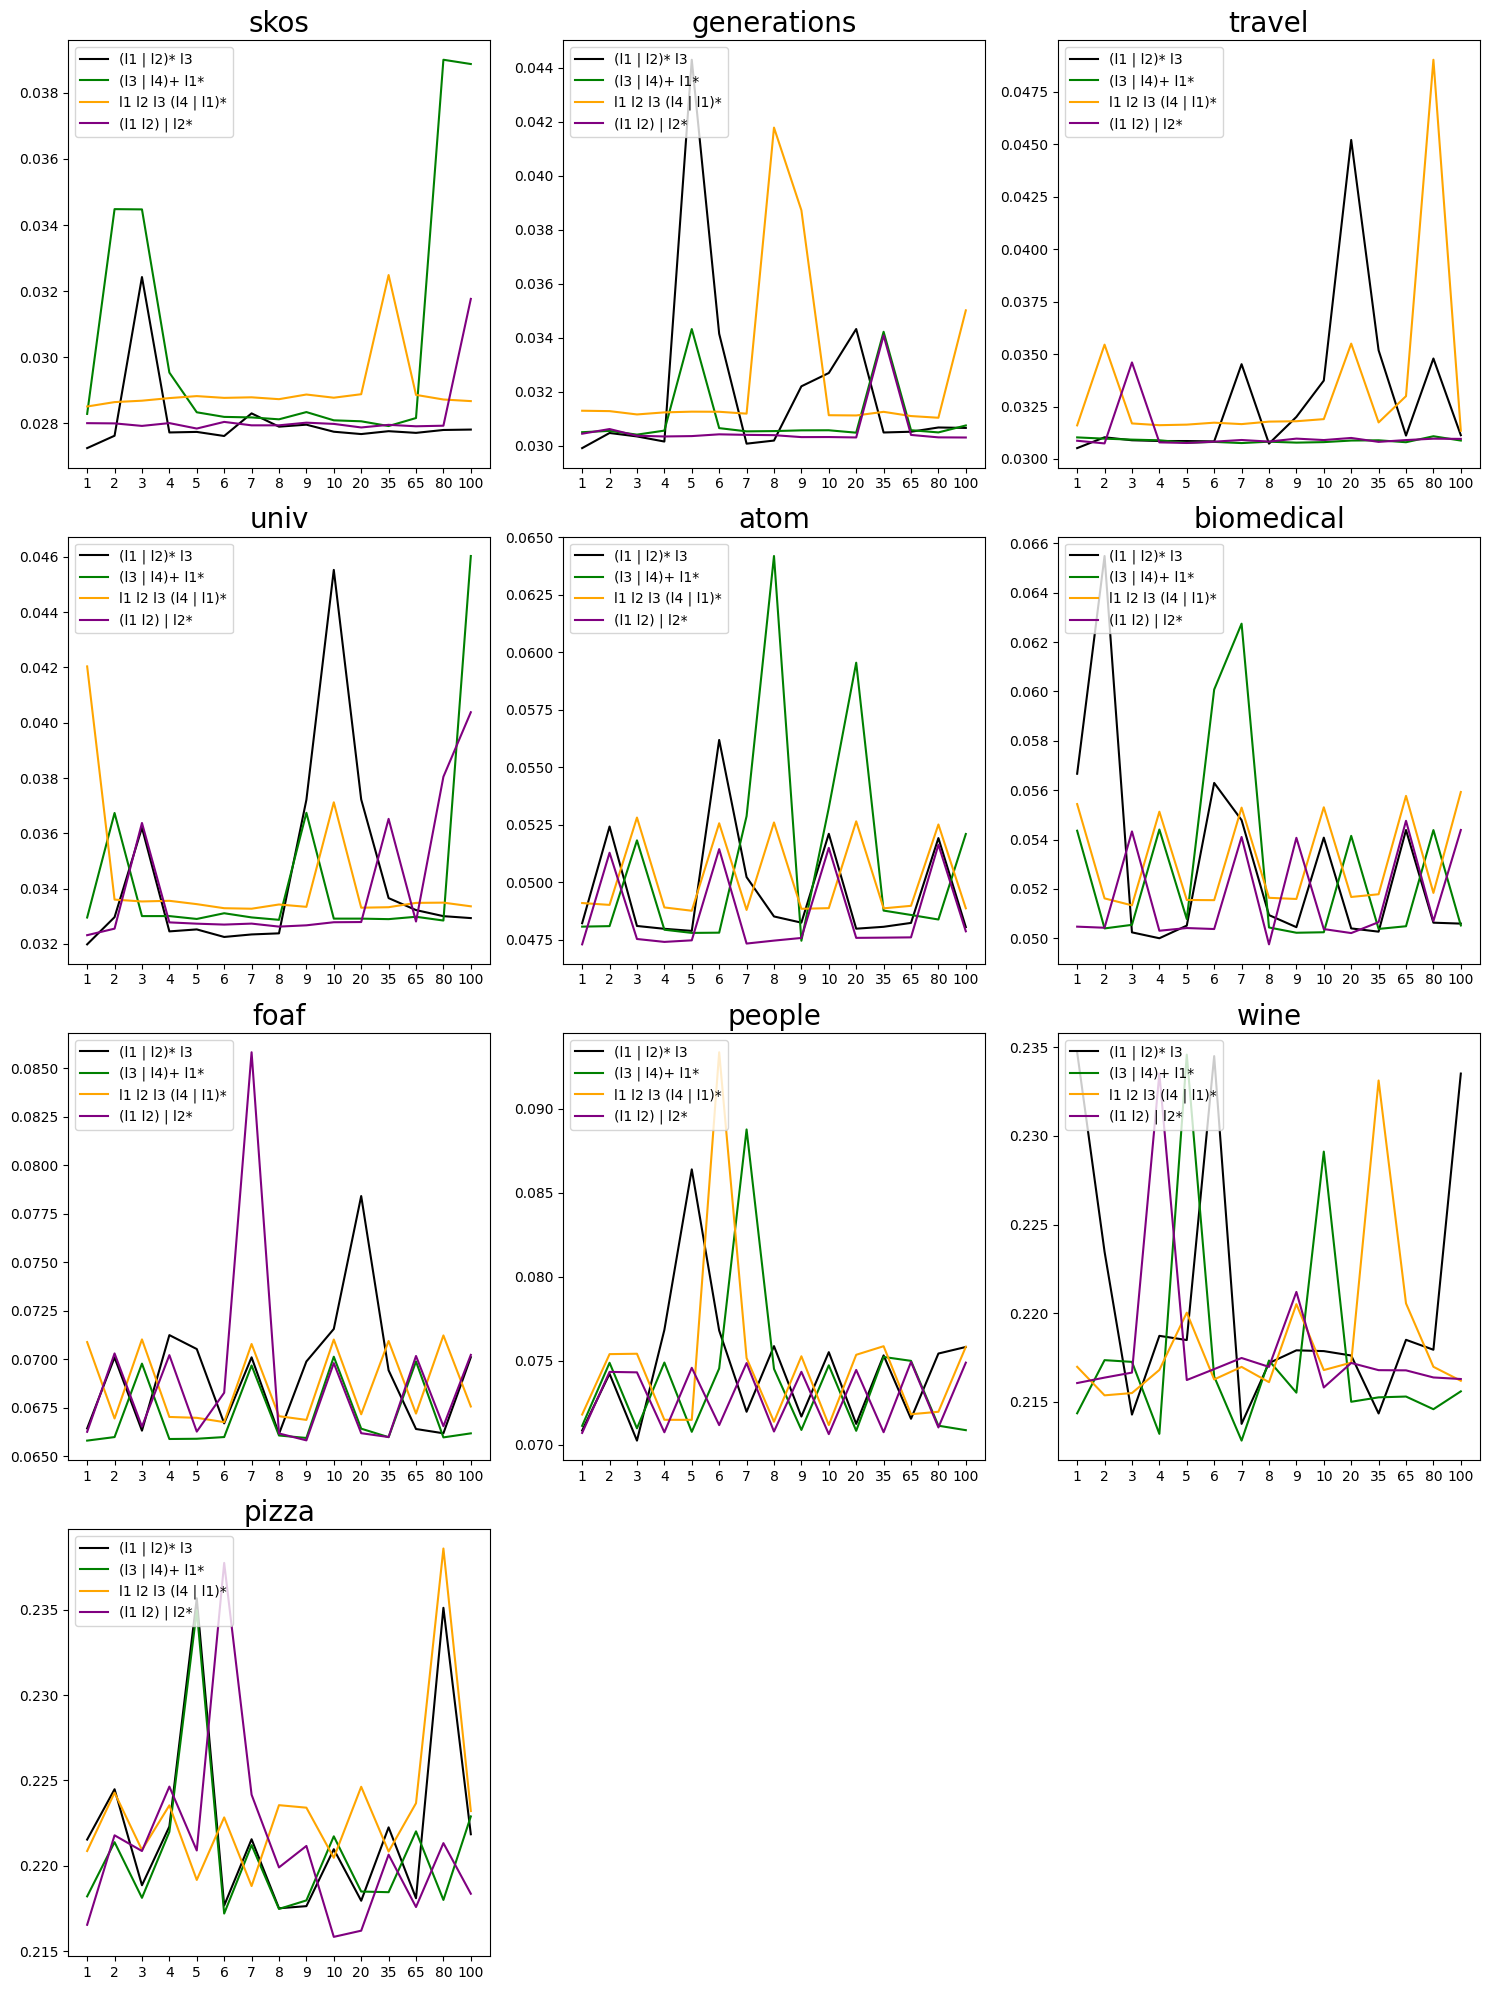

In [70]:
rpq_methods_comparison(tensor_based_rpq)

Аналогично сделаем замеры для `ms_bfs_based_rpq`, взяв также за тип матрицы `csr_matrix`:

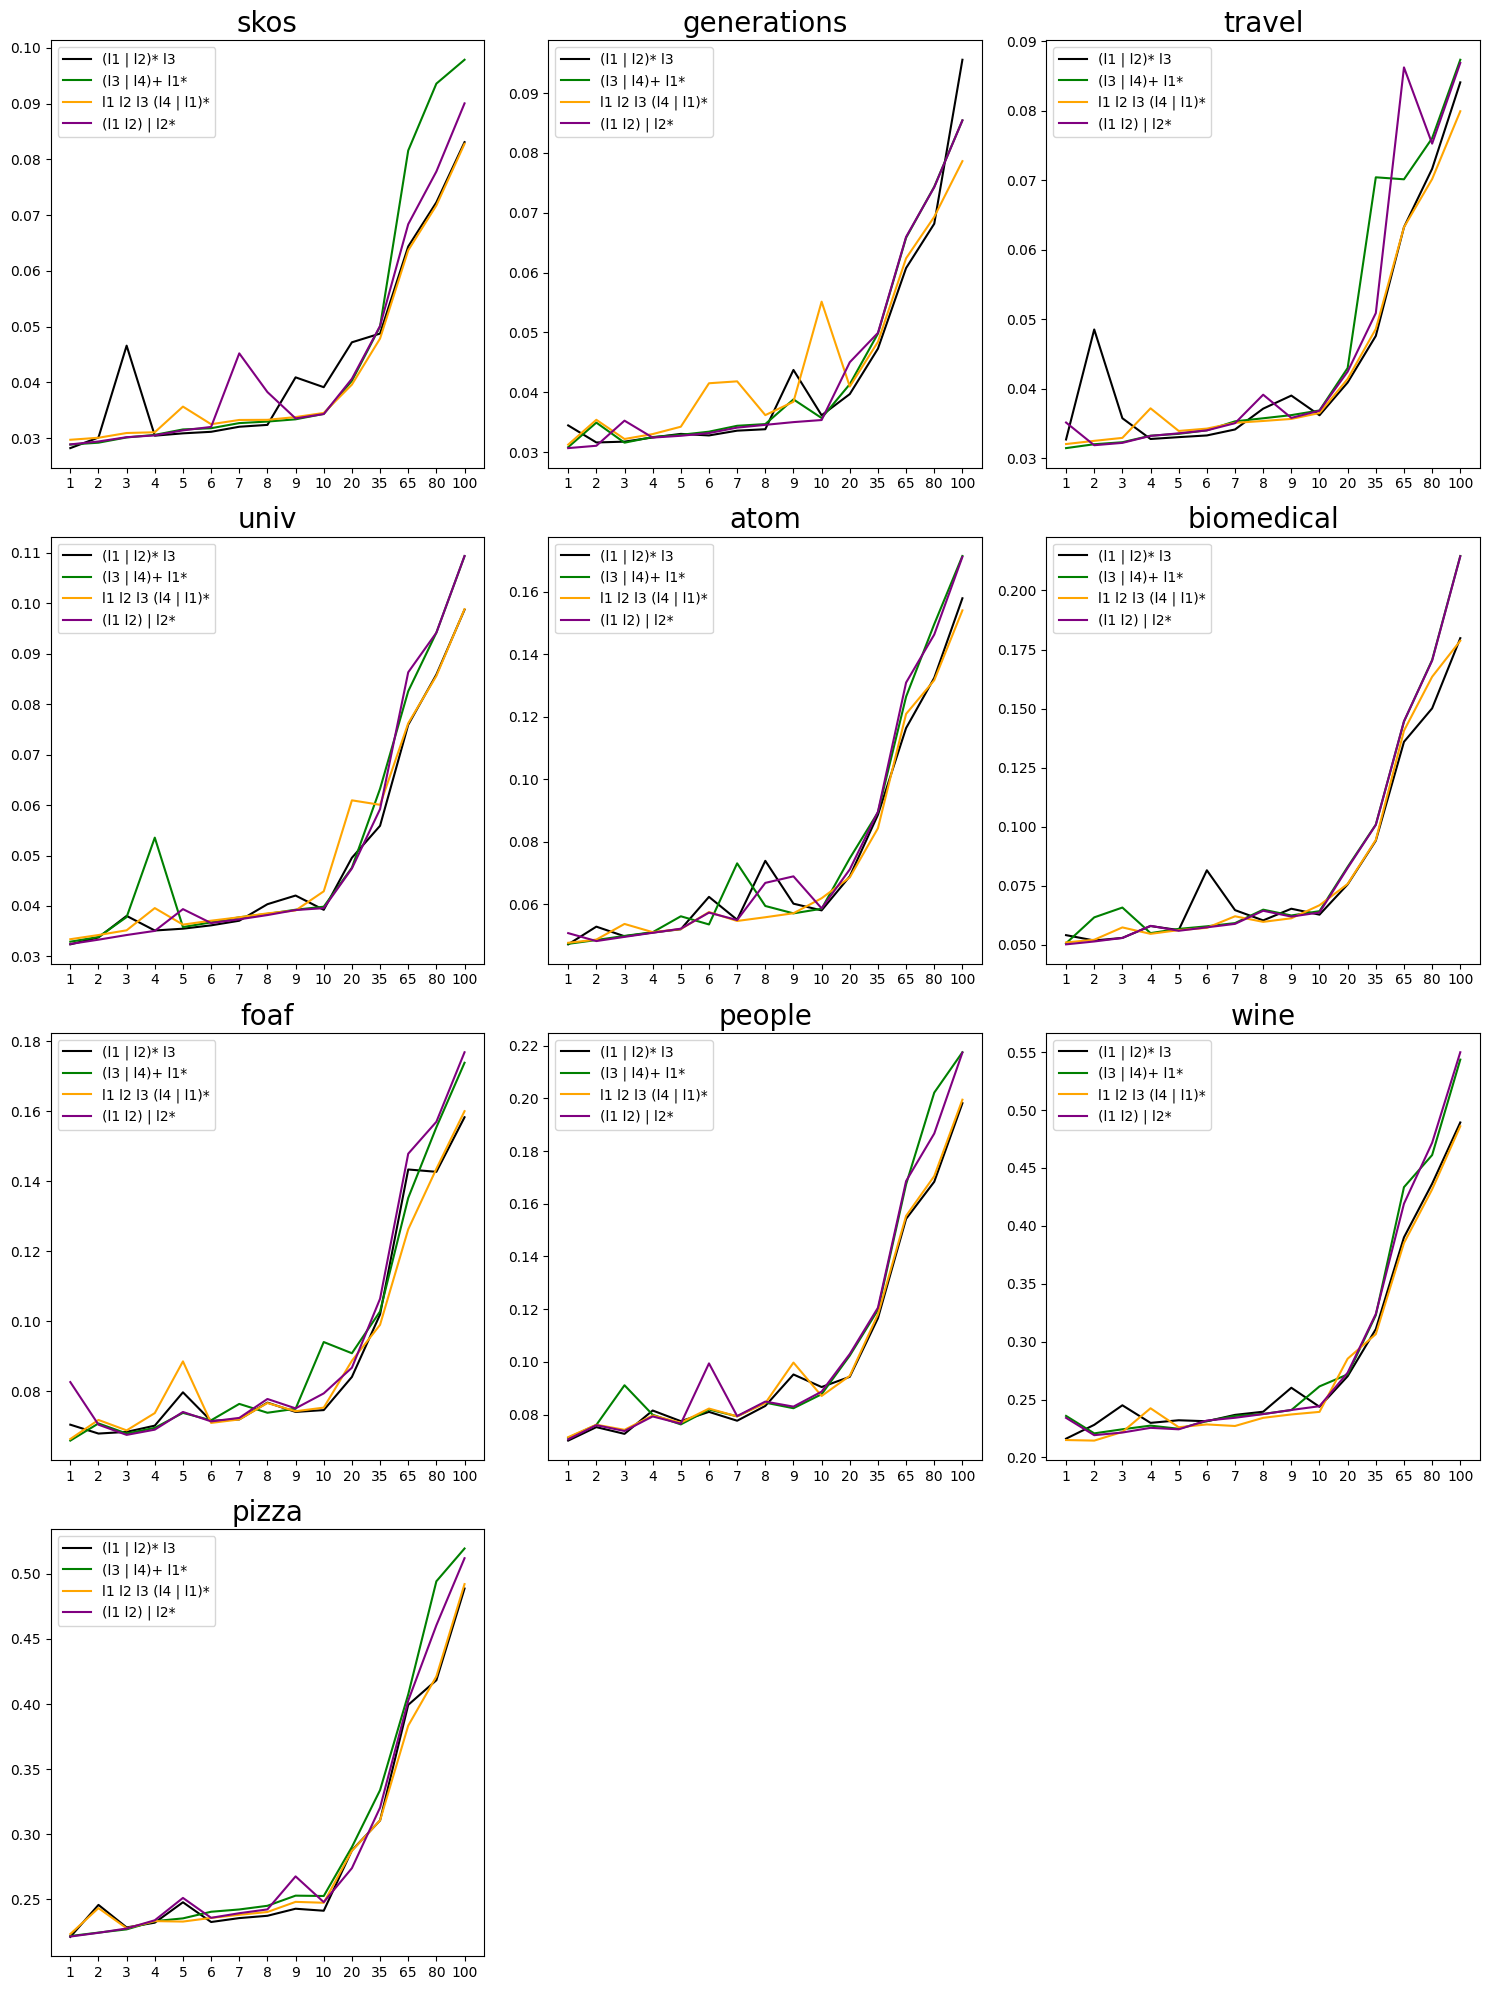

In [71]:
rpq_methods_comparison(ms_bfs_based_rpq)

#### Вывод: 
Исходя из результатов, можно увидеть общую тенденцию того, что производительность `ms_bfs_based_rpq` падет с ростом числа стартовых вершин. Однако, нельзя однозначно определить точное число, когда стоит использовать другой алгоритм. В общем случае, для `ms_bfs_based_rpq` лучше брать как можно меньшее множество стартовых вершин.

Результаты можно аргументировать тем, что в основе алгоритма лежит multiple source bfs, т.е ростом числа стартовых вершин, `frontier` растет линейно, из-за чего трудно выявить конкректное число, начиная с которого мы получим сильный упадок в производительности